<a href="https://colab.research.google.com/github/Alaa-abdelmajied/Face_Recognition/blob/main/Assignment1_%5B5467%5D%5B5591%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dataset
[datasets used(download link)](https://drive.google.com/drive/folders/1f5uI08WvyPxKNvbR1Wc4S0_f3Zr9qDEh?usp=sharing)

In [ ]:
!unzip faces -d dataset
!unzip animals

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import scipy
from numpy.linalg import eig,eigh
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Generating the data matrix


In [ ]:
# Generating the data matrix

def getDataMatrixFaces (path, imgNum, classNum, dataOnly):
  counter = 0
  imgSize = 92*112
  data = np.zeros((imgNum,imgSize))
  labels = np.zeros((imgNum,1))
  for folderNum in range(1,classNum+1):
    folderPath = 's' + str(folderNum)
    folderPath = os.path.join(path,folderPath)
    for imageNum in range(1,11):
      imagePath = str(imageNum) + '.pgm'
      imagePath = os.path.join(folderPath,imagePath)
      image = cv2.imread(imagePath,0)
      data[counter,:] = image.flatten()
      labels[counter] = int(folderNum)
      counter += 1
  if dataOnly == False:
    return data, labels
  else:
    return data

In [ ]:
def getDataMatrixNonAndFaces (path, imgNum):
  counter = 0
  imgSize = 92*112
  data = np.zeros((imgNum,imgSize))

  # labels 0 = non faces, 1 = faces
  labels = np.zeros((imgNum,1))
  for count in range(400):
    data[count,:] = getDataMatrixFaces('/content/dataset',400,40,True)[count,:]
    labels[count] = 1
  count +=1
  for imageName in os.listdir(path):
    if count != imgNum :
      imagePath = os.path.join(path,imageName)
      image = cv2.imread(imagePath,0)
      image = cv2.resize(image, (92,112))
      data[count,:] = image.flatten()
      labels[count] = 0
      count +=1
    else:
      break
  return data,labels

# Splitting Dataset

In [ ]:
# Splitting the data matrix 

def splitDataMatrix(data, labels):

  imgSize = 92*112

  trainData = np.zeros((int(len(data)/2),imgSize))
  testData = np.zeros((int(len(data)/2),imgSize))
  testCount = 0;

  trainLabels = np.zeros((int(len(data)/2),1))
  testLabels = np.zeros((int(len(data)/2),1))
  trainCount = 0;

  for count in range(0,len(data)):
    if count%2 == 0:
      testData[testCount] = data[count]
      testLabels[testCount] = labels[count]
      testCount +=1
    else:
      trainData[trainCount] = data[count]
      trainLabels[trainCount] = labels[count]
      trainCount +=1
  
  return trainData, trainLabels, testData, testLabels

# KNN classifer 

In [ ]:
def knn(trainData,trainLabels,testData,testLabels,k,showSucess_Failure):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(trainData,trainLabels.ravel())
  pred = knn.predict(testData)
  if showSucess_Failure == True:
    cm = pd.DataFrame(
       metrics.confusion_matrix(testLabels, pred, labels=[1, 0]), 
      index=['true:faces', 'true:non faces'], 
      columns=['pred:faces', 'pred:non faces'])
    print(cm)
    print('\n')
  accuracy  = metrics.accuracy_score(testLabels,pred)
  return accuracy

# Classificaition using PCA

In [ ]:
def PCA_reduction(alpha,eigen_values,eigen_vectors,trainData,testData):
  totalVariance=sum(eigen_values)
  currentVariance=0
  for i in range(len(trainData[0])): 
     currentVariance=sum(eigen_values[:i])
     explained_variance=currentVariance/totalVariance
     if(explained_variance>=alpha):
       U=eigen_vectors[:,:i]
       break
  reducedTrainData=np.dot(U.T,trainData.T)
  reducedTestData=np.dot(U.T,testData.T)
  
  return reducedTrainData,reducedTestData


def FindEigenVal_Vec(trainData):

  mean_trainData = np.mean(trainData,axis = 0)
  centeredMat_trainData= trainData-mean_trainData
  covarianceMat_trainData = np.cov(centeredMat_trainData.transpose(),bias=1)
  
  eigen_values, eigen_vectors = scipy.linalg.eigh(covarianceMat_trainData,turbo=True)

  idx=eigen_values.argsort()[::-1]
  eigen_values=eigen_values[idx]
  eigen_vectors=eigen_vectors[:,idx]

  return eigen_values,eigen_vectors

In [ ]:
def KNN_classifierPCA(trainData,trainLabels,testData,testLabels,eigen_values,eigen_vectors):

  alphas = [0.8,0.85,0.9,0.95]
  neighbours=[1,3,5,7]
  accuracy=[]

  for i in neighbours:
    accuracy[:]=[]
    count = 0
    print('@ k= ',i)
    for alpha in alphas:
      reducedTrainData,reducedTestData=PCA_reduction(alpha,eigen_values,eigen_vectors,trainData,testData)
      accuracy.append(knn(reducedTrainData.T,trainLabels,reducedTestData.T,testLabels,i,False))
      print('when alpha=',alpha,'accuracy=',accuracy[count])
      count +=1

    plt.plot(alphas,accuracy,label='k='+str(i))
    plt.xlabel('alphas')
    plt.ylabel('accuracy')
    plt.title("Accuracy when k=1,3,5,7 and alpha=0.8,0.85,0.9,0.95")
    
    plt.legend(loc='upper right')
    
  for alpha in alphas:
    accuracy[:]=[]
    count = 0
    print('@ alpha= ',alpha)
    for i in neighbours:
      reducedTrainData,reducedTestData=PCA_reduction(alpha,eigen_values,eigen_vectors,trainData,testData)
      accuracy.append(knn(reducedTrainData.T,trainLabels,reducedTestData.T,testLabels,i,False))
      print('when k=',i,',accuracy=',accuracy[count])
      count +=1

    plt.figure()
    plt.plot(neighbours,accuracy)
    plt.xlabel('K')
    plt.ylabel('accuracy')
    plt.title('@ Alpha = '+str(alpha))

In [ ]:
def PCA_accuracyPlotting(ratios,accuracy):
 for i in range(len(ratios)):
    ratios[i]=ratios[i]-400
    print('Accuracy at alpha=0.8, k = 1, when number of non-faces images = '+ str(ratios[i])+' is: ' + str(accuracy[i]))
 plt.plot(ratios,accuracy)
 plt.xlabel('number of non-faces images')
 plt.ylabel('accuracy')
 plt.title('Accuracy at Alpha = 0.8, K=1 ')
 plt.show()

## Faces  using PCA - function call

@ k=  1
when alpha= 0.8 accuracy= 0.93
when alpha= 0.85 accuracy= 0.94
when alpha= 0.9 accuracy= 0.945
when alpha= 0.95 accuracy= 0.935
@ k=  3
when alpha= 0.8 accuracy= 0.855
when alpha= 0.85 accuracy= 0.855
when alpha= 0.9 accuracy= 0.85
when alpha= 0.95 accuracy= 0.845
@ k=  5
when alpha= 0.8 accuracy= 0.805
when alpha= 0.85 accuracy= 0.83
when alpha= 0.9 accuracy= 0.815
when alpha= 0.95 accuracy= 0.815
@ k=  7
when alpha= 0.8 accuracy= 0.78
when alpha= 0.85 accuracy= 0.775
when alpha= 0.9 accuracy= 0.755
when alpha= 0.95 accuracy= 0.74
@ alpha=  0.8
when k= 1 ,accuracy= 0.93
when k= 3 ,accuracy= 0.855
when k= 5 ,accuracy= 0.805
when k= 7 ,accuracy= 0.78
@ alpha=  0.85
when k= 1 ,accuracy= 0.94
when k= 3 ,accuracy= 0.855
when k= 5 ,accuracy= 0.83
when k= 7 ,accuracy= 0.775
@ alpha=  0.9
when k= 1 ,accuracy= 0.945
when k= 3 ,accuracy= 0.85
when k= 5 ,accuracy= 0.815
when k= 7 ,accuracy= 0.755
@ alpha=  0.95
when k= 1 ,accuracy= 0.935
when k= 3 ,accuracy= 0.845
when k= 5 ,accuracy= 0.

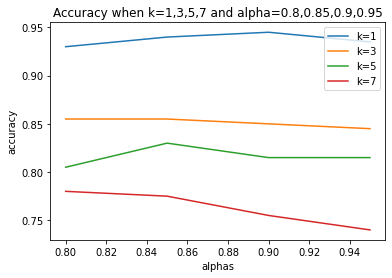

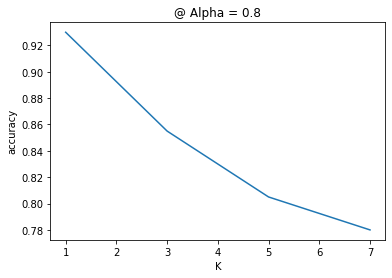

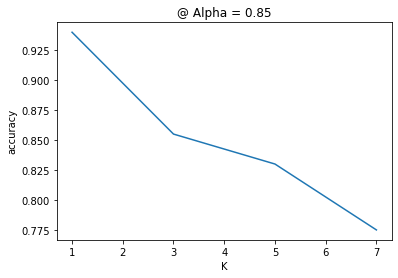

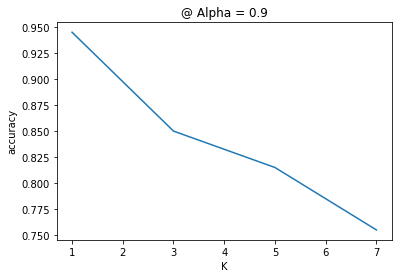

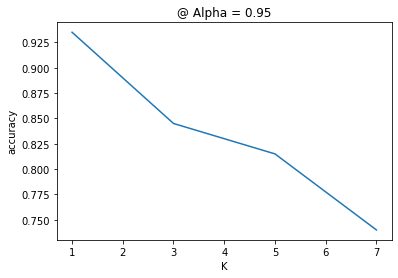

In [ ]:
data,labels= getDataMatrixFaces('/content/dataset', 400,40,False)
trainData, trainLabels, testData, testLabels = splitDataMatrix(data,labels)
eigen_values,eigen_vectors=FindEigenVal_Vec(trainData)
KNN_classifierPCA(trainData, trainLabels, testData, testLabels,eigen_values,eigen_vectors)

##Faces vs Non-faces using PCA - function call


At number of faces = 400 and non faces = 200
                pred:faces  pred:non faces
true:faces             200               0
true:non faces          19              81


At number of faces = 400 and non faces = 400
                pred:faces  pred:non faces
true:faces             200               0
true:non faces          34             166


At number of faces = 400 and non faces = 800
                pred:faces  pred:non faces
true:faces             200               0
true:non faces          57             343


At number of faces = 400 and non faces = 1200
                pred:faces  pred:non faces
true:faces             200               0
true:non faces          63             537


Accuracy at alpha=0.8, k = 1, when number of non-faces images = 200 is: 0.9366666666666666
Accuracy at alpha=0.8, k = 1, when number of non-faces images = 400 is: 0.915
Accuracy at alpha=0.8, k = 1, when number of non-faces images = 800 is: 0.905
Accuracy at alpha=0.8, k = 1, when number of non

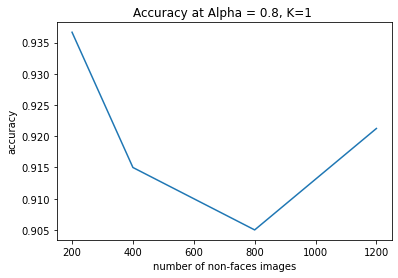

In [ ]:
k=1
alpha=0.8
accuracy=[]
ratios=[600,800,1200,1600]

for ratio in ratios:
  data,labels=getDataMatrixNonAndFaces ('/content/animals', ratio)
  trainData, trainLabels, testData, testLabels = splitDataMatrix(data,labels)
  eigen_values,eigen_vectors=FindEigenVal_Vec(trainData)
  reducedTrainData,reducedTestData=PCA_reduction(alpha,eigen_values,eigen_vectors,trainData,testData)
  print("At number of faces = 400 and non faces = " + str(ratio - 400))
  accuracy.append(knn(reducedTrainData.T,trainLabels,reducedTestData.T,testLabels,k,True))
PCA_accuracyPlotting(ratios,accuracy)


# Classification using LDA

In [ ]:
def LDA (trainData, testData):
  
  imgSize = 92*112
 
  #Calculate the overall mean
  overallMeanLDA = np.mean(trainData,axis = 0)
 
  #Calculate each class mean
  classMean = np.zeros((int(len(trainData)/5),imgSize))
  for i in range(0,len(trainData),5):
    classMean[int(i/5)] = np.mean(trainData[i:i+5,:],axis = 0)
 
  #Calculate Sb
  sb = np.zeros((imgSize,imgSize))
  for i in range(int(len(trainData)/5)):
    sb +=  5 * np.outer((classMean[i] - overallMeanLDA),(classMean[i] - overallMeanLDA).T)
 
  #Calculate the center class matrix (Zi)
  centerClassMatLDA = np.zeros((len(trainData),imgSize))
  for i in range(len(trainData)):
    centerClassMatLDA[i] = trainData[i] - classMean[int(i/5)]
 
  #Calculate the within class scatter matrix (S)
  withinClassScatterMatLDA = np.zeros((imgSize,imgSize))
  for i in range(0,len(trainData),5):
    centerClassMat=centerClassMatLDA[i:i+5]
    withinClassScatterMatLDA += np.dot(centerClassMat.T,centerClassMat) 
  
  #Getting the within class scatter matrix inverse
  withinClassScatterMatLDAinv = scipy.linalg.pinvh(withinClassScatterMatLDA)

  #Calculating the eignvalues and eignvectors
  eValues,eVectors = scipy.linalg.eigh(np.dot(withinClassScatterMatLDAinv,sb),turbo=True)
 
  #Getting the dominant 39 eignvectors
  index = eValues.argsort()[-39:][::-1]
  
  #Creating the projection matrix
  U = eVectors[:,index]
 
  #Reduction of train data and test data
  reducedTrain = np.dot(U.T,trainData.T)
  reducedTest = np.dot(U.T,testData.T)
 
  return reducedTrain, reducedTest

In [ ]:
def LDA_NonFaces(trainData,trainLabels,testData,testLabels):

  imgSize = 92*112

  facesClass=trainData[0:200,:]
  nonFacesClass=trainData[200:,:]

  classMean1=np.mean(facesClass,axis=0)
  classMean2=np.mean(nonFacesClass,axis=0)

  meanDifference=(classMean1-classMean2)
  betweenClassScatterMat=np.outer(meanDifference.T,meanDifference)

  centerClassMat1=facesClass-classMean1
  centerClassMat2=nonFacesClass-classMean2
  
  classScatterMat1=np.dot(centerClassMat1.T,centerClassMat1)
  classScatterMat2=np.dot(centerClassMat2.T,centerClassMat2)

  withinClassScatterMat=np.zeros((imgSize,imgSize))
  withinClassScatterMat=classScatterMat1+classScatterMat2

  withinClassScatterMatInv=scipy.linalg.pinvh(withinClassScatterMat)
  sInv_B=np.dot(withinClassScatterMatInv,betweenClassScatterMat)
  
  eigenValues,eigenVectors=scipy.linalg.eigh(sInv_B,turbo= True)

  eigenVectors = np.flip(eigenVectors, axis = 1)
  U = eigenVectors[:,0]

  reducedTrain = np.dot(U.T,trainData.T)
  reducedTest = np.dot(U.T,testData.T)

  k=1
  accuracy=knn(reducedTrain.T.reshape(-1, 1),trainLabels,reducedTest.T.reshape(-1, 1),testLabels,k,True)

  return  accuracy

In [ ]:
 def KNN_ClassifierLDA(reducedTrain,trainLabels,reducedTest,testLabels):
   accuracy=[]
   neighbours=[1,3,5,7]
   count = 0
   for i in neighbours:
     accuracy.append(knn(reducedTrain.T,trainLabels,reducedTest.T,testLabels,i,False))
     print('Accuracy at k = ' + str(i) + ' is: ' + str(accuracy[count]))
     count +=1
   plt.plot(neighbours,accuracy)
   plt.xlabel('K')
   plt.ylabel('accuracy')
   plt.show()

In [ ]:
def LDA_accuracyPlotting(ratios,accuracy):
  for i in range(len(ratios)):
    ratios[i]=ratios[i]-400
    print('Accuracy at k = 1, when number of non-faces images = '+ str(ratios[i])+' is: ' + str(accuracy[i]))
  plt.plot(ratios,accuracy)
  plt.xlabel('number of non-faces images')
  plt.ylabel('accuracy')
  plt.title('Accuracy at K=1 ')
  plt.show()

## Faces using LDA - function call

Accuracy at k = 1 is: 0.95
Accuracy at k = 3 is: 0.875
Accuracy at k = 5 is: 0.865
Accuracy at k = 7 is: 0.84


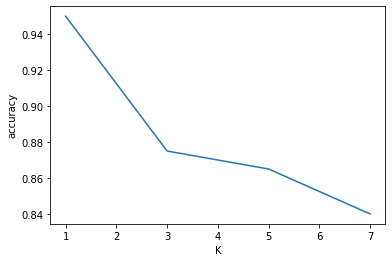

In [ ]:
data,labels = getDataMatrixFaces ('/content/dataset', 400, 40, False)
trainData, trainLabels, testData, testLabels = splitDataMatrix(data,labels)
reducedTrain,reducedTest= LDA(trainData,testData)
KNN_ClassifierLDA(reducedTrain,trainLabels,reducedTest,testLabels)


## Faces vs Non-faces using LDA - function call

At number of faces = 400 and non faces = 200
                pred:faces  pred:non faces
true:faces             181              19
true:non faces          14              86


At number of faces = 400 and non faces = 400
                pred:faces  pred:non faces
true:faces             169              31
true:non faces          27             173


At number of faces = 400 and non faces = 800
                pred:faces  pred:non faces
true:faces             148              52
true:non faces          63             337


At number of faces = 400 and non faces = 1200
                pred:faces  pred:non faces
true:faces             137              63
true:non faces          91             509


Accuracy at k = 1, when number of non-faces images = 200 is: 0.89
Accuracy at k = 1, when number of non-faces images = 400 is: 0.855
Accuracy at k = 1, when number of non-faces images = 800 is: 0.8083333333333333
Accuracy at k = 1, when number of non-faces images = 1200 is: 0.8075


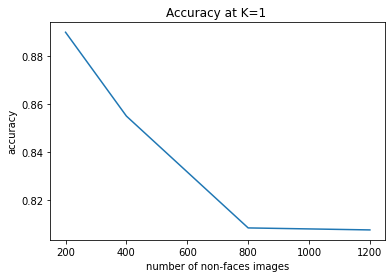

In [ ]:
ratios=[600,800,1200,1600]
accuracy=[]
for ratio in ratios:
  data,labels = getDataMatrixNonAndFaces ('/content/animals', ratio)
  trainData, trainLabels, testData, testLabels = splitDataMatrix(data,labels)
  print("At number of faces = 400 and non faces = " + str(ratio - 400))
  accuracy.append(LDA_NonFaces(trainData,trainLabels,testData,testLabels))
LDA_accuracyPlotting(ratios,accuracy)

#Bonus

1. Data splitting

2. Classification using PCA
* PCA using faces dataset
* PCA using faces and non faces dataset

3. Classification using LDA 
* LDA using faces dataset
* LDA using faces and non faces dataset





## Data Splitting

In [ ]:
def splitDataMatrixBouns(data, labels):
 
  imgSize = 92*112
 
  trainData = np.zeros((int(len(data)*0.7),imgSize))
  testData = np.zeros((int(len(data)*0.3),imgSize))
  testCount = 0;
 
  trainLabels = np.zeros((int(len(data)*0.7),1))
  testLabels = np.zeros((int(len(data)*0.3),1))
  trainCount = 0;
 
  for count in range(0,len(data)):
    if count%10 < 7:
      trainData[trainCount] = data[count]
      trainLabels[trainCount] = labels[count]
      trainCount +=1
    else :
      testData[testCount] = data[count]
      testLabels[testCount] = labels[count]
      testCount +=1
 
  return trainData, trainLabels, testData, testLabels

## PCA (faces dataset) - function call

@ k=  1
when alpha= 0.8 accuracy= 0.9583333333333334
when alpha= 0.85 accuracy= 0.9666666666666667
when alpha= 0.9 accuracy= 0.9666666666666667
when alpha= 0.95 accuracy= 0.95
@ k=  3
when alpha= 0.8 accuracy= 0.925
when alpha= 0.85 accuracy= 0.9333333333333333
when alpha= 0.9 accuracy= 0.9166666666666666
when alpha= 0.95 accuracy= 0.9416666666666667
@ k=  5
when alpha= 0.8 accuracy= 0.9083333333333333
when alpha= 0.85 accuracy= 0.9083333333333333
when alpha= 0.9 accuracy= 0.8916666666666667
when alpha= 0.95 accuracy= 0.9
@ k=  7
when alpha= 0.8 accuracy= 0.8416666666666667
when alpha= 0.85 accuracy= 0.8416666666666667
when alpha= 0.9 accuracy= 0.85
when alpha= 0.95 accuracy= 0.8
@ alpha=  0.8
when k= 1 ,accuracy= 0.9583333333333334
when k= 3 ,accuracy= 0.925
when k= 5 ,accuracy= 0.9083333333333333
when k= 7 ,accuracy= 0.8416666666666667
@ alpha=  0.85
when k= 1 ,accuracy= 0.9666666666666667
when k= 3 ,accuracy= 0.9333333333333333
when k= 5 ,accuracy= 0.9083333333333333
when k= 7 ,accu

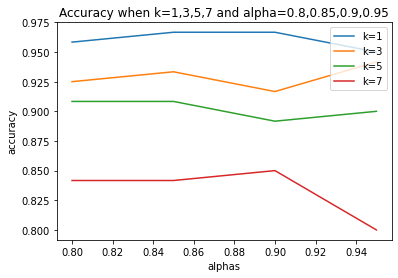

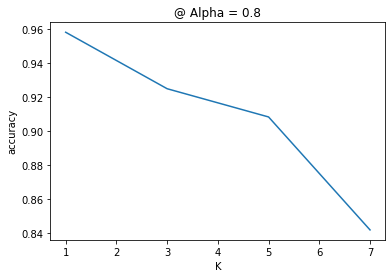

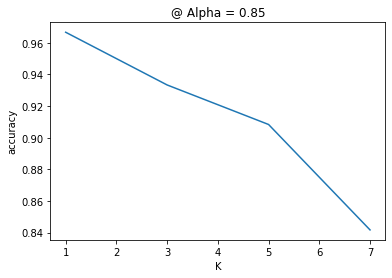

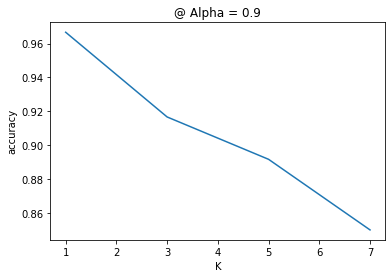

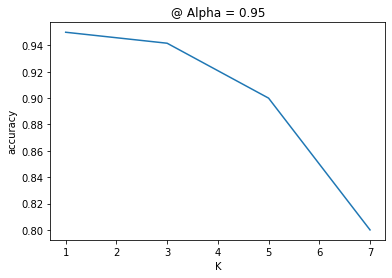

In [ ]:
#PCA using faces dataset

data,labels= getDataMatrixFaces('/content/dataset', 400,40,False)
trainData, trainLabels, testData, testLabels = splitDataMatrixBouns(data,labels)
eigen_values,eigen_vectors=FindEigenVal_Vec(trainData)
KNN_classifierPCA(trainData,trainLabels,testData,testLabels,eigen_values,eigen_vectors)

## PCA (faces and non faces dataset) - function call

At number of faces = 400 and non faces = 200
                pred:faces  pred:non faces
true:faces             120               0
true:non faces           7              53


At number of faces = 400 and non faces = 400
                pred:faces  pred:non faces
true:faces             120               0
true:non faces          17             103


At number of faces = 400 and non faces = 800
                pred:faces  pred:non faces
true:faces             120               0
true:non faces          20             220


At number of faces = 400 and non faces = 1200
                pred:faces  pred:non faces
true:faces             120               0
true:non faces          23             337


Accuracy at alpha=0.8, k = 1, when number of non-faces images = 200 is: 0.9611111111111111
Accuracy at alpha=0.8, k = 1, when number of non-faces images = 400 is: 0.9291666666666667
Accuracy at alpha=0.8, k = 1, when number of non-faces images = 800 is: 0.9444444444444444
Accuracy at alpha=0.8,

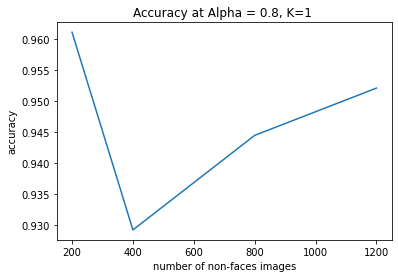

In [ ]:
#PCA using faces and non faces dataset

k=1
alpha=0.8
accuracy=[]
ratios=[600,800,1200,1600]

for ratio in ratios:
  data,labels=getDataMatrixNonAndFaces ('/content/animals', ratio)
  trainData, trainLabels, testData, testLabels = splitDataMatrixBouns(data,labels)
  eigen_values,eigen_vectors=FindEigenVal_Vec(trainData)
  reducedTrainData,reducedTestData=PCA_reduction(alpha,eigen_values,eigen_vectors,trainData,testData)
  print("At number of faces = 400 and non faces = " + str(ratio - 400))
  accuracy.append(knn(reducedTrainData.T,trainLabels,reducedTestData.T,testLabels,k,True))
PCA_accuracyPlotting(ratios,accuracy)


## LDA (faces dataset) - function call

Accuracy at k = 1 is: 0.9583333333333334
Accuracy at k = 3 is: 0.9416666666666667
Accuracy at k = 5 is: 0.9333333333333333
Accuracy at k = 7 is: 0.9083333333333333


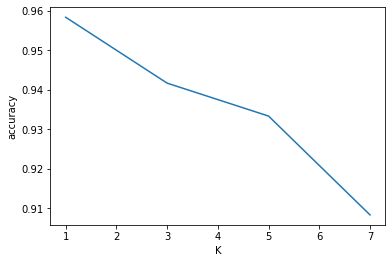

In [ ]:
#LDA using faces dataset

data,labels = getDataMatrixFaces ('/content/dataset', 400, 40, False)
trainData, trainLabels, testData, testLabels = splitDataMatrixBouns(data,labels)
reducedTrain,reducedTest= LDA(trainData,testData)
KNN_ClassifierLDA(reducedTrain,trainLabels,reducedTest,testLabels)

## LDA (faces and non faces dataset) - function call

At number of faces = 400 and non faces = 200
                pred:faces  pred:non faces
true:faces             112               8
true:non faces          13              47


At number of faces = 400 and non faces = 400
                pred:faces  pred:non faces
true:faces             103              17
true:non faces          25              95


At number of faces = 400 and non faces = 800
                pred:faces  pred:non faces
true:faces              95              25
true:non faces          32             208


At number of faces = 400 and non faces = 1200
                pred:faces  pred:non faces
true:faces              86              34
true:non faces          39             321


Accuracy at k = 1, when number of non-faces images = 200 is: 0.8833333333333333
Accuracy at k = 1, when number of non-faces images = 400 is: 0.825
Accuracy at k = 1, when number of non-faces images = 800 is: 0.8416666666666667
Accuracy at k = 1, when number of non-faces images = 1200 is: 0.8479

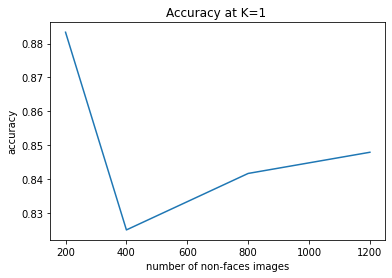

In [ ]:
#LDA using faces and non faces dataset

ratios=[600,800,1200,1600]
accuracy=[]
for ratio in ratios:
  data,labels = getDataMatrixNonAndFaces ('/content/animals', ratio)
  trainData, trainLabels, testData, testLabels = splitDataMatrixBouns(data,labels)
  print("At number of faces = 400 and non faces = " + str(ratio - 400))
  accuracy.append(LDA_NonFaces(trainData,trainLabels,testData,testLabels))
LDA_accuracyPlotting(ratios,accuracy)